> ### Note on Labs and Assignments:
>
> 🔧 Look for the **wrench emoji** 🔧 — it highlights where you're expected to take action!
>
> These sections are graded and are not optional.
>

# IS 4487 Lab 13: Sentiment Analysis

## Outline

- Analyze a dataset utilizing sentiment
- Compare the VADER and TextBlob models
- Learn the basics of sentiment analysis

In this lab, you will explore **sentiment analysis** techniques to determine the positivity/negativity of certain sentences.

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/lab_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Data Description

We will use a dataset containing movie reviews.  Each review is contained in the "Phrase" variable.  This dataset is pre-labeled with the Sentiment, but we will use tools to calculate our own Sentiment, which could then be compared to the pre-labeled values.  

The dataset does not specify the movie that it is reviewing.  We wouldn't be able to use this to calculate a movie score, like Rotten Tomatoes.  But we can observe the overall sentiment of reviewers and practice using the text analytics tools available in Python.

| Column                        | Data Type       | Description                                                  |
|------------------------------|------------------|--------------------------------------------------------------|
| `PhraseID`                   | Integer           | ID of an entry                                               |
| `SentenceID`                 | Integer           | Shows which phrases belong to which sentence                                      |
| `Phrase`             | String       | A sentence/phrase                       |
| `Sentiment`                 | Categorical       | 0 = Very Negative, 1 = Negative, 2 = Neutral, 3 = Positive, 4= Highly Positive        |

Source: https://www.kaggle.com/datasets/satwikdondapati/moviereviewsentimentalanalysis

## Part 1: Load and Prepare the Data

### What you are going to do:
- Load the dataset
- Preview the data

### Why this matters:
All throughout the semester you've mainly dealt with data that had a wide variety of types. But what if we only have a few variables and one of them has tons of data?

**Things to notice:**
- Which variables are actually important?
- Why are there so few variables? Which variable(s) has the most data?


### 🔧 Try It Yourself
Import the libraries and dataset

In [24]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pandas as pd
import csv

# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/movie_reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


# Part 2 : See the Scores
### What you are going to do:
- count how many entries belong to each Sentiment score
- create a visualization of the value counts

### Why this matters:
In the dataset you'll notice that each phrase has a sentiment score. These scores tell us whether a phrase is positive or negative or neutral in tone. In later steps we will be predicting scores, so it is important to know if there is any skew of sentiment within the data.  

**Things to notice:**
- Why are there 5 total Sentiment scores?
- What does each score mean?
- What is the count of each score?

### 🔧 Try It Yourself — Part 2

1. create a variable that stores the ```value_counts``` of the Sentiment column
2. create a bar chart using the ```value_counts``` variable you just created

### In Your Response:
1. make a comment about the chart. Is there any skew within the data? Is it more positive, negative, or neutral? (Hint: refer to the data dictionary at the very top)

In [27]:
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['Sentiment Score', 'Count']
sentiment_counts_df = sentiment_counts_df.sort_values(by='Sentiment Score')
display(sentiment_counts_df)

,Sentiment Score,Count
4,0,7072
2,1,27273
0,2,79582
1,3,32927
3,4,9206


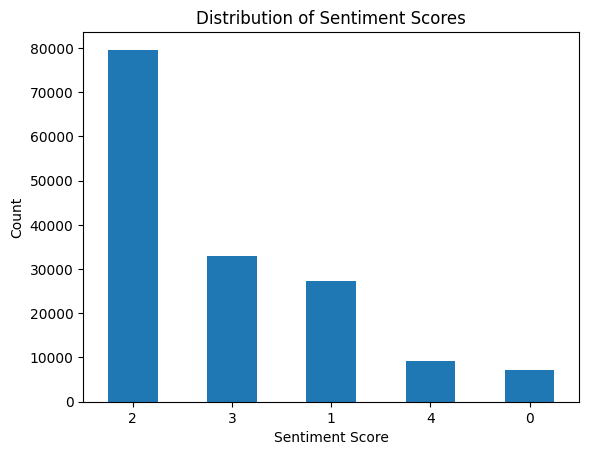

In [35]:
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### ✍️ Your Response: 🔧
1. The overall distribution is skewed towards the sentiment score of 2 (Neutural) which is significantly higher than all the other sentiment scores.

# Part 3: VADER
### What you are going to do:
- run and train a VADER model
- evaluate its performance

### Why this matters:
VADER is a rule based model great for handling short sentences and phrases. It works by looking at each word individually and assigning an individual score to it. These scores then get compounded at the end of its calculation and it generates a sentiment score. Since it looks at one word at a time it may struggle with longer sentences. So VADER is best suited for analyzing social media and reviews.

**Things to notice:**
- what does the score_to_label function do?

In [29]:
# set up and run the VADER model
sia = SentimentIntensityAnalyzer()

df["vader_score"] = [sia.polarity_scores(text)["compound"] for text in df["Phrase"]]

# there are a total of 5 sentiment scores but polarity only gives us scores between -1 to 1
# need to map the scores from the dataset so that polarity can use it
def score_to_label(score):
    if score <= -0.6:
        return 0  # very negative
    elif score <= -0.2:
        return 1  # somewhat negative
    elif score < 0.2:
        return 2  # neutral
    elif score < 0.6:
        return 3  # somewhat positive
    else:
        return 4  # very positive

df["vader_pred"] = df["vader_score"].apply(score_to_label)

# View the predicted score
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,vader_score,vader_pred
0,1,1,A series of escapades demonstrating the adage ...,1,0.5579,3
1,2,1,A series of escapades demonstrating the adage ...,2,0.4404,3
2,3,1,A series,2,0.0000,2
3,4,1,A,2,0.0000,2
4,5,1,series,2,0.0000,2


### 🔧 Try It Yourself — Part 3
Now we know if the data is positively, negatively, or neutrally skewed. For the next two steps we are going to be testing out 2 new models and comparing their results.
1. using ```vader_pred``` and ```Sentiment``` generate a classification report
2. using ```vader_pred``` and ```Sentiment``` generate a confusion matrix

### In Your Response:
1. make a comment. Why are the values for a sentiment score of 2 much higher than all the others?

In [30]:
print(classification_report(df['Sentiment'], df['vader_pred']))

              precision    recall  f1-score   support

           0       0.22      0.14      0.17      7072
           1       0.38      0.26      0.31     27273
           2       0.65      0.74      0.69     79582
           3       0.40      0.38      0.39     32927
           4       0.27      0.33      0.30      9206

    accuracy                           0.53    156060
   macro avg       0.38      0.37      0.37    156060
weighted avg       0.51      0.53      0.51    156060



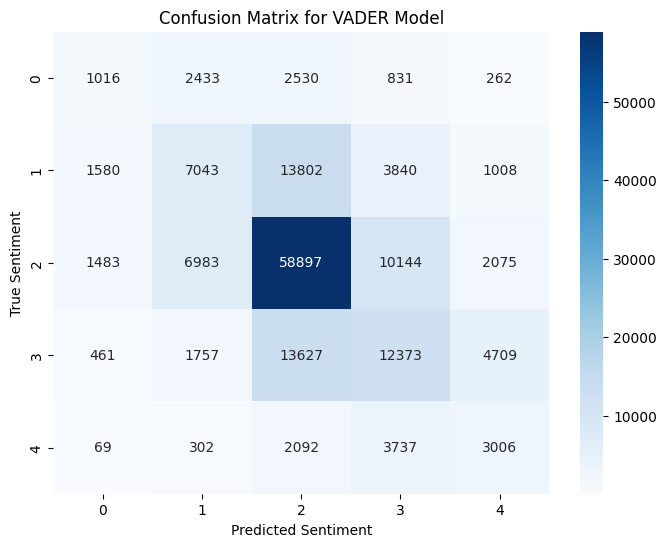

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(df['Sentiment'], df['vader_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix for VADER Model')
plt.show()

### ✍️ Your Response: 🔧
1. From what I've gathered, because the neural networks make up such a large quantity of the dataset, it will naturally show a larger amount of neutral values. Both the correctly and incorectly predicted values of neutral will be high because of the overall amount of neutral data in the dataset.



# Part 4: TextBlob
### What you are going to do:
- evaluate the performance of a TextBlob model

## Why this matters:
Unlike VADER, TextBlod utilizes tokenization to determine the sentiment of a phrase. Tokenization is great for breaking up large sentences and paragraphs. Because of this, TextBlob works better on longer sentences and is best suited for analyzing longer text documents such as articles or blogs.

**Things to notice:**
- how does accuracy compare to the previous model?

In [32]:

# set up and run the textblob model
df["textblob_score"] = [TextBlob(text).sentiment.polarity for text in df["Phrase"]]
df["textblob_pred"] = df["textblob_score"].apply(score_to_label)

# View the predicted score
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,vader_score,vader_pred,textblob_score,textblob_pred
0,1,1,A series of escapades demonstrating the adage ...,1,0.5579,3,0.4,3
1,2,1,A series of escapades demonstrating the adage ...,2,0.4404,3,0.7,4
2,3,1,A series,2,0.0000,2,0.0,2
3,4,1,A,2,0.0000,2,0.0,2
4,5,1,series,2,0.0000,2,0.0,2


### 🔧 Try It Yourself — Part 4
Now let's evaluate the TextBlob model.
1. using ```textblob_pred``` and ```Sentiment``` generate a classification report
2. using ```textblob_pred``` and ```Sentiment``` generate a confusion matrix

### In Your Response:
1. make a comment. Why are the values for a sentiment score of 2 much higher than all the others?

In [33]:
print(classification_report(df['Sentiment'], df['textblob_pred']))

              precision    recall  f1-score   support

           0       0.25      0.11      0.15      7072
           1       0.38      0.16      0.22     27273
           2       0.60      0.81      0.69     79582
           3       0.38      0.31      0.34     32927
           4       0.25      0.19      0.21      9206

    accuracy                           0.52    156060
   macro avg       0.37      0.31      0.32    156060
weighted avg       0.48      0.52      0.48    156060



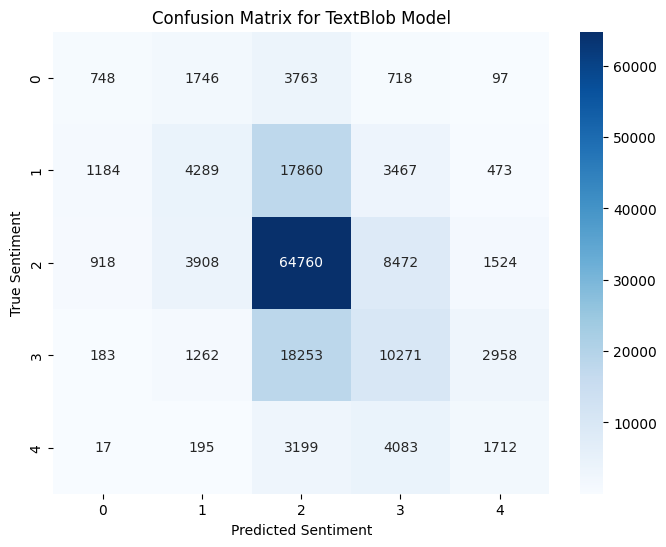

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix_textblob = confusion_matrix(df['Sentiment'], df['textblob_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_textblob, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3', '4'],
            yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix for TextBlob Model')
plt.show()

### ✍️ Your Response: 🔧
1. The sentiment score values are high, the same reason as the VADER model. The data is heavily made up of the neutral sentiment therefore there are going to be more values that are 2.


## 🔧 Part 5: Reflection (100 words or less)

In this lab you built a VADER and TextBlob model and evaluated their results. You also learned about some of the pros and cons of each model and in which situations they would be used.

Use the cell below to answer the following questions:

1. In the dataset there was a certain sentiment score that had an extremely high frequency. How did the high number of frequency for this score affect its associated metrics?
1. Which model had better accuracy in this lab? Why is that the case? (Hint: look at the results of head() at the very top of this lab. How long are the phrases in this dataset?)
2. Why is it important for a business to determine sentiment? How could a business use sentiment analysis and customer reviews to improve customer service?

### ✍️ Your Response: 🔧
1. The high number of frequency significantly affected the metreics. Although the precisions scores of the VADER and textblob model arent terrible, it is likely just because the Neutural looks strong in the results mainly because it makes up most of the model, not necessarily because the model is good at identifying it.

2. The model that had the best accuracy in this lab was the VADER model. This is probably because the text listed at the top is very short and VADER models do best with short amounts of text.

3. It is important for businesses to determine sentiment because it gives them a lot of insights on their social media, reviews, customer feedback etc. This understanding can impact strategic descisions for the business. Businesses can use this information to try to increase customer satisfaction, make changes based on reviews, make sure the brand has a good image, etc.

# Export Your Notebook to Submit in Canvas
Use the instructions from Lab 1

In [ ]:
!jupyter nbconvert --to html "lab_13_LastnameFirstname.ipynb"